# Pre-Processing

## Imports and Environment Setup

In [1]:
# Configure Keras backend to use TensorFlow for consistent behavior
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Core Python libraries for data processing and visualization
import re                    # Regular expressions for text preprocessing
import numpy as np          # Numerical operations and array handling
import matplotlib.pyplot as plt  # Image display and result visualization

# Deep learning framework and components
import tensorflow as tf     # Main deep learning framework
import keras               # High-level neural network API
from keras import layers   # Building blocks for neural network architecture
from keras.layers import TextVectorization  # Text-to-sequence conversion layer
from keras.applications import efficientnet  # Pre-trained CNN models for feature extraction

# Training utilities and callbacks
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Ensure reproducible results across different runs
keras.utils.set_random_seed(111)

# Display framework versions for debugging and compatibility checking
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("Environment setup complete!")

TensorFlow version: 2.18.0
Keras version: 3.8.0
Environment setup complete!


## Dataset Download

In [2]:
# Download Flickr8K dataset from official repository
print("Downloading Flickr8K dataset...")
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip  # Image dataset (8,000 images)
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip     # Caption annotations

# Extract downloaded archives
print("Extracting dataset...")
!unzip -qq Flickr8k_Dataset.zip  # Extract images to Flicker8k_Dataset folder
!unzip -qq Flickr8k_text.zip     # Extract caption files

# Clean up downloaded zip files to save disk space
print("Cleaning up zip files...")
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

print("Dataset setup complete!")


Extracting dataset...
Cleaning up zip files...
Dataset setup complete!


## Model Configuartion

In [3]:
# Dataset paths and file structure
IMAGES_PATH = "Flicker8k_Dataset"  # Path to extracted images (note: original spelling)

# Image processing parameters
IMAGE_SIZE = (299, 299)  # Input image dimensions - optimized for EfficientNet architecture
                         # Size is divisible by 32 for efficient CNN processing

# Text processing parameters
VOCAB_SIZE = 12000      # Maximum vocabulary size for text tokenization
SEQ_LENGTH = 25         # Maximum caption length in tokens (including start/end tokens)

# Model architecture parameters
EMBED_DIM = 512         # Embedding dimension for both image and text features
FF_DIM = 1024          # Feed-forward network dimension (2x embedding_dim is standard)
NUM_HEADS = 8          # Number of attention heads (must divide evenly into embed_dim)
NUM_ENCODER_LAYERS = 3  # Number of transformer encoder layers for image processing
NUM_DECODER_LAYERS = 3  # Number of transformer decoder layers for caption generation

# Training hyperparameters
BATCH_SIZE = 16         # Training batch size (balanced for memory efficiency)
EPOCHS = 30            # Number of training epochs
DROPOUT_RATE = 0.15    # Dropout probability for regularization

# TensorFlow optimization settings
AUTOTUNE = tf.data.AUTOTUNE  # Automatic performance tuning for data pipeline

# Display configuration summary for verification
print(f"\nModel Configuration Summary:")
print(f"├── Image Processing:")
print(f"│   ├── Input Size: {IMAGE_SIZE}")
print(f"│   └── Dataset Path: {IMAGES_PATH}")
print(f"├── Text Processing:")
print(f"│   ├── Vocabulary Size: {VOCAB_SIZE:,}")
print(f"│   └── Sequence Length: {SEQ_LENGTH}")
print(f"├── Architecture:")
print(f"│   ├── Embedding Dimension: {EMBED_DIM}")
print(f"│   ├── Feed-Forward Dimension: {FF_DIM}")
print(f"│   ├── Attention Heads: {NUM_HEADS}")
print(f"│   ├── Encoder Layers: {NUM_ENCODER_LAYERS}")
print(f"│   └── Decoder Layers: {NUM_DECODER_LAYERS}")
print(f"└── Training:")
print(f"    ├── Batch Size: {BATCH_SIZE}")
print(f"    ├── Epochs: {EPOCHS}")
print(f"    └── Dropout Rate: {DROPOUT_RATE}")


Model Configuration Summary:
├── Image Processing:
│   ├── Input Size: (299, 299)
│   └── Dataset Path: Flicker8k_Dataset
├── Text Processing:
│   ├── Vocabulary Size: 12,000
│   └── Sequence Length: 25
├── Architecture:
│   ├── Embedding Dimension: 512
│   ├── Feed-Forward Dimension: 1024
│   ├── Attention Heads: 8
│   ├── Encoder Layers: 3
│   └── Decoder Layers: 3
└── Training:
    ├── Batch Size: 16
    ├── Epochs: 30
    └── Dropout Rate: 0.15


## Data Loading and Splitting

### Functions

In [4]:
def load_captions_data(filename):
    """
    Loads caption data from Flickr8K annotation file and maps them to corresponding images.

    Args:
        filename: Path to the caption annotation file (e.g., "Flickr8k.token.txt")

    Returns:
        tuple: (caption_mapping dict, text_data list)
    """
    # Initialize data structures for storing processed captions
    caption_mapping = {}    # Maps image paths to lists of captions
    text_data = []         # All processed captions as a flat list
    images_to_skip = set() # Images that don't meet quality criteria
    skipped_lines = 0      # Counter for malformed lines in the file

    print(f"Loading captions from {filename}...")

    # Read and process the caption annotation file
    with open(filename, 'r', encoding='utf-8') as caption_file:
        for line_num, line in enumerate(caption_file, 1):
            line = line.strip()

            # Skip empty lines to avoid processing errors
            if not line:
                continue

            # Verify line format: should contain tab separator between image name and caption
            if '\t' not in line:
                skipped_lines += 1
                continue

            try:
                # Split on first tab only (captions might contain tabs)
                img_name, caption = line.split('\t', 1)
            except ValueError:
                skipped_lines += 1
                continue

            # Extract base image name by removing caption number suffix (#0, #1, etc.)
            img_name = img_name.split('#')[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # Clean and validate caption text
            caption = caption.strip()
            if not caption:  # Skip empty captions
                images_to_skip.add(img_name)
                continue

            # Normalize caption text for consistent processing
            caption = caption.lower()                        # Convert to lowercase
            caption = re.sub(r'\s+', ' ', caption)          # Normalize whitespace
            caption = re.sub(r'[^\w\s\-\']', '', caption)   # Remove punctuation except hyphens and apostrophes

            # Tokenize caption and check length constraints
            tokens = caption.split()

            # Filter captions by length (reserve space for start/end tokens)
            if len(tokens) < 2 or len(tokens) > SEQ_LENGTH - 2:
                images_to_skip.add(img_name)
                continue

            # Process valid JPEG images that haven't been marked for skipping
            if img_name.endswith('.jpg') and img_name not in images_to_skip:
                # Add special tokens for sequence modeling
                processed_caption = "<start> " + caption + " <end>"
                text_data.append(processed_caption)

                # Group multiple captions per image
                if img_name in caption_mapping:
                    caption_mapping[img_name].append(processed_caption)
                else:
                    caption_mapping[img_name] = [processed_caption]

    # Clean up: remove any images that were marked for skipping
    for img_name in images_to_skip:
        if img_name in caption_mapping:
            del caption_mapping[img_name]

    # Report loading statistics
    print(f"Loaded {len(caption_mapping)} images with {len(text_data)} captions")
    print(f"Skipped {skipped_lines} malformed lines")
    print(f"Skipped {len(images_to_skip)} images due to filtering")

    return caption_mapping, text_data

def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """
    Split the caption dataset into training and validation sets.

    Args:
        caption_data: Dictionary mapping image paths to caption lists
        train_size: Fraction of data to use for training (0.0 to 1.0)
        shuffle: Whether to randomly shuffle the data before splitting

    Returns:
        tuple: (training_data dict, validation_data dict)
    """
    # Validate input parameters
    if not caption_data:
        raise ValueError("Caption data is empty")

    if not (0 < train_size < 1):
        raise ValueError("train_size must be between 0 and 1")

    # Get list of all image paths
    all_images = list(caption_data.keys())

    # Optionally shuffle for random distribution
    if shuffle:
        np.random.shuffle(all_images)

    # Calculate split point ensuring at least one sample in each set
    train_count = int(len(all_images) * train_size)
    train_count = max(1, min(train_count, len(all_images) - 1))

    # Create training and validation dictionaries
    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_count]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_count:]
    }

    return training_data, validation_data

### Execution

In [5]:
# Load and process caption data with comprehensive error handling
try:
    # Load raw caption data from annotation file
    captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

    # Verify data was loaded successfully
    if not captions_mapping:
        raise ValueError("No valid captions loaded. Check your data file.")

    # Split dataset into training and validation sets
    train_data, valid_data = train_val_split(captions_mapping)

    # Display dataset split information
    print(f"\nDataset Split Summary:")
    print(f"├── Training samples: {len(train_data)}")
    print(f"└── Validation samples: {len(valid_data)}")

    # Calculate and display dataset statistics
    total_captions = sum(len(captions) for captions in captions_mapping.values())
    avg_captions_per_image = total_captions / len(captions_mapping)

    print(f"\nDataset Statistics:")
    print(f"├── Total captions: {total_captions:,}")
    print(f"├── Average captions per image: {avg_captions_per_image:.1f}")

    # Analyze caption length distribution for model configuration validation
    caption_lengths = [len(caption.split()) for caption in text_data[:100]]
    print(f"└── Sample caption length range: {min(caption_lengths)}-{max(caption_lengths)} words")

except FileNotFoundError:
    print("Error: Flickr8k.token.txt not found. Make sure the dataset is downloaded.")
except Exception as e:
    print(f"Error loading data: {str(e)}")

Loading captions from Flickr8k.token.txt...
Loaded 7898 images with 39818 captions
Skipped 0 malformed lines
Skipped 193 images due to filtering

Dataset Split Summary:
├── Training samples: 6318
└── Validation samples: 1580

Dataset Statistics:
├── Total captions: 39,490
├── Average captions per image: 5.0
└── Sample caption length range: 7-22 words


## Text Vectorization Setup

In [6]:
# Define punctuation characters to remove during text preprocessing
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"  # Standard punctuation marks
strip_chars = strip_chars.replace("<", "")  # Preserve '<' for <start> token
strip_chars = strip_chars.replace(">", "")  # Preserve '>' for <end> token

def custom_standardization(input_string):
    """
    Custom text standardization function that cleans text while preserving special tokens.

    This function:
    - Converts text to lowercase for consistency
    - Removes punctuation except angle brackets (for special tokens)
    - Maintains word boundaries and spacing

    Args:
        input_string: Raw text string to be standardized

    Returns:
        Cleaned text string ready for tokenization
    """
    # Convert to lowercase for consistent vocabulary
    lowercase = tf.strings.lower(input_string)

    # Remove specified punctuation while preserving special token markers
    cleaned_text = tf.strings.regex_replace(
        lowercase,
        "[%s]" % re.escape(strip_chars),  # Escape special regex characters
        ""  # Replace with empty string
    )

    return cleaned_text

# Create text vectorization layer for converting text to integer sequences
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,              # Maximum vocabulary size (most frequent words)
    output_mode="int",                  # Output integer token IDs instead of one-hot vectors
    output_sequence_length=SEQ_LENGTH,  # Pad/truncate sequences to fixed length
    standardize=custom_standardization, # Apply our custom text cleaning function
)

# Adapt vectorization layer to the actual text data to build vocabulary
print("Adapting vectorization to text data...")
vectorization.adapt(text_data)  # Analyzes text_data to create vocabulary mapping

# Verify vectorization setup and display vocabulary information
vocab = vectorization.get_vocabulary()  # Get the learned vocabulary list
print(f"\nVectorization Setup Complete:")
print(f"├── Vocabulary size: {len(vocab):,}")
print(f"├── First 10 tokens: {vocab[:10]}")
print(f"├── Special tokens preserved: '<start>', '<end>'")
print(f"└── Sequence length: {SEQ_LENGTH} tokens")

# Display sample tokenization for verification
if text_data:
    sample_caption = text_data[0]  # Get first caption for testing
    sample_tokens = vectorization([sample_caption])  # Tokenize sample
    print(f"\nSample Tokenization:")
    print(f"├── Original: {sample_caption}")
    print(f"└── Tokenized: {sample_tokens[0].numpy()[:10]}...")  # Show first 10 tokens

Adapting vectorization to text data...

Vectorization Setup Complete:
├── Vocabulary size: 8,739
├── First 10 tokens: ['', '[UNK]', np.str_('a'), np.str_('<start>'), np.str_('<end>'), np.str_('in'), np.str_('the'), np.str_('on'), np.str_('is'), np.str_('and')]
├── Special tokens preserved: '<start>', '<end>'
└── Sequence length: 25 tokens

Sample Tokenization:
├── Original: <start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>
└── Tokenized: [  3   2  43   5   2  91 173   8 117  54]...


## Image Augmentation Setup

In [7]:
# Create data augmentation pipeline to improve model generalization during training
image_augmentation = keras.Sequential([
    # Horizontal flipping: mirrors images left-to-right (50% probability)
    # Helps model learn that object orientation doesn't affect caption content
    layers.RandomFlip("horizontal"),

    # Random rotation: rotates images by up to ±15 degrees
    # Builds robustness to camera tilt and slight orientation changes
    layers.RandomRotation(0.15),

    # Contrast adjustment: varies image contrast by ±20%
    # Simulates different lighting conditions and camera settings
    layers.RandomContrast(0.2),

    # Brightness variation: adjusts image brightness by ±10%
    # Helps model handle different illumination scenarios
    layers.RandomBrightness(0.1),

    # Zoom transformation: randomly zooms in/out by ±10%
    # Simulates different distances from subject and cropping variations
    layers.RandomZoom(0.1),

], name="image_augmentation")  # Named for easier debugging and model inspection

print("Image augmentation pipeline created successfully!")

# Display augmentation configuration for verification
print(f"\nAugmentation Pipeline Configuration:")
print(f"├── Horizontal Flip: Enabled (50% probability)")
print(f"├── Rotation Range: ±{0.15 * 180:.1f} degrees")
print(f"├── Contrast Variation: ±{0.2 * 100:.0f}%")
print(f"├── Brightness Variation: ±{0.1 * 100:.0f}%")
print(f"└── Zoom Range: ±{0.1 * 100:.0f}%")

print(f"\nNote: Augmentations are applied randomly during training only")
print(f"      Validation and inference use original images without augmentation")

Image augmentation pipeline created successfully!

Augmentation Pipeline Configuration:
├── Horizontal Flip: Enabled (50% probability)
├── Rotation Range: ±27.0 degrees
├── Contrast Variation: ±20%
├── Brightness Variation: ±10%
└── Zoom Range: ±10%

Note: Augmentations are applied randomly during training only
      Validation and inference use original images without augmentation


## Data Pipeline Creation

In [8]:
def decode_and_resize(img_path):
    """
    Load and preprocess a single image from file path for model input.

    This function handles the complete image preprocessing pipeline:
    - Loads image from disk
    - Decodes JPEG format to tensor
    - Resizes to model input dimensions
    - Normalizes pixel values to [0,1] range

    Args:
        img_path: String path to the image file

    Returns:
        Preprocessed image tensor of shape (height, width, 3)
    """
    # Read raw image file from disk as binary data
    img = tf.io.read_file(img_path)

    # Decode JPEG binary data to 3-channel RGB tensor
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize image to model's expected input dimensions
    img = tf.image.resize(img, IMAGE_SIZE)

    # Convert pixel values from [0,255] integers to [0,1] float32 for training
    img = tf.image.convert_image_dtype(img, tf.float32)

    return img

def process_input(img_path, captions):
    """
    Process a single training example containing image path and associated captions.

    This function coordinates the preprocessing of both image and text data:
    - Loads and preprocesses the image
    - Vectorizes the caption text to integer sequences

    Args:
        img_path: String path to the image file
        captions: List of caption strings for this image

    Returns:
        Tuple of (preprocessed_image, vectorized_captions)
    """
    # Process image through the preprocessing pipeline
    processed_image = decode_and_resize(img_path)

    # Convert caption text to integer token sequences using the trained vectorizer
    vectorized_captions = vectorization(captions)

    return processed_image, vectorized_captions

def make_dataset(images, captions, is_training=True):
    """
    Create an optimized TensorFlow dataset pipeline for efficient batch processing.

    This function builds a complete data pipeline with:
    - Parallel data loading and preprocessing
    - Optional shuffling for training data
    - Batching for efficient GPU utilization
    - Infinite repetition for training to support multiple epochs
    - Prefetching for pipeline optimization

    Args:
        images: List of image file paths
        captions: List of caption lists (multiple captions per image)
        is_training: Boolean flag to enable/disable shuffling and repetition

    Returns:
        Optimized tf.data.Dataset ready for model training/validation
    """
    # Create initial dataset from image paths and caption lists
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))

    # Apply shuffling only to training data for randomization
    if is_training:
        # Use large buffer size for thorough shuffling with fixed seed for reproducibility
        dataset = dataset.shuffle(buffer_size=BATCH_SIZE * 16, seed=42)

    # Apply preprocessing function with parallel processing for speed
    dataset = dataset.map(
        process_input,
        num_parallel_calls=AUTOTUNE  # TensorFlow automatically optimizes parallelism
    )

    # Group examples into batches for efficient training
    dataset = dataset.batch(BATCH_SIZE)

    # Repeat dataset indefinitely during training to avoid running out of data across epochs
    if is_training:
        dataset = dataset.repeat()  # Essential for multi-epoch training

    # Prefetch next batch while current batch is being processed (pipeline optimization)
    dataset = dataset.prefetch(AUTOTUNE)

    return dataset

### Dataset Creation & Verification

In [9]:
# Create optimized training dataset with shuffling enabled
print("Creating training dataset...")
train_dataset = make_dataset(
    list(train_data.keys()),    # Image file paths
    list(train_data.values()),  # Corresponding caption lists
    is_training=True           # Enable shuffling for training
)

# Create validation dataset without shuffling for consistent evaluation
print("Creating validation dataset...")
valid_dataset = make_dataset(
    list(valid_data.keys()),    # Image file paths
    list(valid_data.values()),  # Corresponding caption lists
    is_training=False          # Disable shuffling for validation
)

# Display dataset creation summary and batch information
print(f"\nDataset Pipeline Created Successfully!")
print(f"├── Training Configuration:")
print(f"│   ├── Total samples: {len(train_data)}")
print(f"│   ├── Estimated batches: ~{len(train_data) // BATCH_SIZE}")
print(f"│   └── Shuffling: Enabled")
print(f"└── Validation Configuration:")
print(f"    ├── Total samples: {len(valid_data)}")
print(f"    ├── Estimated batches: ~{len(valid_data) // BATCH_SIZE}")
print(f"    └── Shuffling: Disabled")

print(f"\nPipeline Optimizations Applied:")
print(f"├── Parallel preprocessing with AUTOTUNE")
print(f"├── Batch size: {BATCH_SIZE}")
print(f"├── Prefetching for improved performance")
print(f"└── Reproducible shuffling with seed=42")

Creating training dataset...
Creating validation dataset...

Dataset Pipeline Created Successfully!
├── Training Configuration:
│   ├── Total samples: 6318
│   ├── Estimated batches: ~394
│   └── Shuffling: Enabled
└── Validation Configuration:
    ├── Total samples: 1580
    ├── Estimated batches: ~98
    └── Shuffling: Disabled

Pipeline Optimizations Applied:
├── Parallel preprocessing with AUTOTUNE
├── Batch size: 16
├── Prefetching for improved performance
└── Reproducible shuffling with seed=42


# Model Architecture


## CNN Feature Extractor

In [10]:
def get_cnn_model():
    """
    Create a CNN feature extractor using pre-trained EfficientNetB0 for image encoding.

    This function builds the image processing component of the captioning model:
    - Uses EfficientNetB0 pre-trained on ImageNet for feature extraction
    - Removes the classification head (include_top=False)
    - Adds custom layers to project features to embedding dimension
    - Freezes pre-trained weights initially for stable training

    Returns:
        Keras Model that converts images to feature vectors of shape (batch, seq_len, embed_dim)
    """
    # Load pre-trained EfficientNetB0 without the classification head
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),  # Input shape: (height, width, channels)
        include_top=False,             # Remove final classification layers
        weights="imagenet",            # Use ImageNet pre-trained weights
    )

    # Freeze the pre-trained weights to prevent updating during initial training
    # This preserves learned ImageNet features and provides stable gradients
    base_model.trainable = False

    # Get the feature maps from the base model
    # Shape: (batch_size, height, width, channels) - typically (batch, 10, 10, 1280)
    base_model_out = base_model.output

    # Reshape feature maps to sequence format for transformer processing
    # Flatten spatial dimensions: (batch, height*width, channels)
    # This treats each spatial location as a sequence element
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)

    # Project CNN features to the embedding dimension used by transformer
    # Maps from CNN feature dimension (1280) to model embedding dimension (EMBED_DIM)
    base_model_out = layers.Dense(EMBED_DIM)(base_model_out)

    # Create the complete CNN feature extractor model
    cnn_model = keras.models.Model(
        inputs=base_model.input,    # Original image input
        outputs=base_model_out,     # Projected feature sequence
        name="cnn_feature_extractor"  # Name for easier debugging
    )

    return cnn_model

## Transformer Encoder Components

In [11]:
class TransformerEncoderBlock(layers.Layer):
    """
    Single transformer encoder block with multi-head self-attention and feed-forward network.

    This block implements the standard transformer encoder architecture with:
    - Multi-head self-attention for capturing relationships between image features
    - Feed-forward network for feature transformation
    - Residual connections and layer normalization for training stability
    - Pre-normalization architecture for improved gradient flow
    """

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        """
        Initialize the transformer encoder block components.

        Args:
            embed_dim: Dimension of input embeddings and model hidden state
            dense_dim: Hidden dimension of the feed-forward network
            num_heads: Number of attention heads for multi-head attention
        """
        super().__init__(**kwargs)

        # Store architecture parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # Multi-head self-attention mechanism
        # Allows the model to attend to different parts of the image simultaneously
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads,                    # Number of parallel attention heads
            key_dim=embed_dim // num_heads,         # Dimension per attention head
            dropout=DROPOUT_RATE                    # Attention dropout for regularization
        )

        # Layer normalization layers for pre-norm transformer architecture
        # Pre-norm helps with training stability and gradient flow
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-6)  # Before attention
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-6)  # Before feed-forward

        # Feed-forward network (FFN) for feature transformation
        self.dense_1 = layers.Dense(dense_dim, activation="gelu")   # Expand to dense_dim
        self.dense_2 = layers.Dense(embed_dim)                     # Project back to embed_dim

        # Dropout layers for regularization to prevent overfitting
        self.dropout_1 = layers.Dropout(DROPOUT_RATE)  # After attention and first FFN layer
        self.dropout_2 = layers.Dropout(DROPOUT_RATE)  # After second FFN layer

    def call(self, inputs, training=None, mask=None):
        """
        Forward pass through the transformer encoder block.

        Args:
            inputs: Input tensor of shape (batch_size, sequence_length, embed_dim)
            training: Boolean flag indicating training vs inference mode
            mask: Optional attention mask to ignore certain positions

        Returns:
            Output tensor of same shape as inputs with enhanced feature representations
        """
        # SELF-ATTENTION SUBLAYER
        # Apply layer normalization before attention (pre-norm architecture)
        normed_inputs = self.layernorm_1(inputs)

        # Compute multi-head self-attention to capture feature relationships
        attn_output = self.attention_1(
            query=normed_inputs,        # What we're looking for
            value=normed_inputs,        # What information we extract
            key=normed_inputs,          # What we match against
            attention_mask=mask,        # Optional masking
            training=training,          # Enable/disable dropout
        )

        # Apply dropout for regularization
        attn_output = self.dropout_1(attn_output, training=training)

        # First residual connection: add attention output to original input
        out_1 = inputs + attn_output

        # FEED-FORWARD SUBLAYER
        # Apply layer normalization before feed-forward network
        normed_out1 = self.layernorm_2(out_1)

        # First FFN layer: expand to larger dimension with GELU activation
        ffn_output = self.dense_1(normed_out1)
        ffn_output = self.dropout_1(ffn_output, training=training)

        # Second FFN layer: project back to original embedding dimension
        ffn_output = self.dense_2(ffn_output)
        ffn_output = self.dropout_2(ffn_output, training=training)

        # Second residual connection: add FFN output to attention sublayer output
        return out_1 + ffn_output

## Transformer Decoder Components

In [12]:
class TransformerDecoderBlock(layers.Layer):
    """
    Single transformer decoder block with masked self-attention and cross-attention.

    This block implements the core decoder functionality with:
    - Masked self-attention to prevent looking at future tokens
    - Cross-attention to attend to encoder outputs (image features)
    - Feed-forward network for feature transformation
    - Pre-normalization architecture for training stability

    Note: This block expects pre-embedded inputs and does not handle embedding internally.
    """

    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        """
        Initialize the transformer decoder block components.

        Args:
            embed_dim: Dimension of input embeddings and model hidden state
            ff_dim: Hidden dimension of the feed-forward network
            num_heads: Number of attention heads for multi-head attention
        """
        super().__init__(**kwargs)

        # Store architecture parameters
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        # Multi-head attention layers
        self.attention_1 = layers.MultiHeadAttention(  # Masked self-attention
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=DROPOUT_RATE
        )
        self.attention_2 = layers.MultiHeadAttention(  # Cross-attention with encoder
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=DROPOUT_RATE
        )

        # Feed-forward network layers
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="gelu")  # Expand dimension
        self.ffn_layer_2 = layers.Dense(embed_dim)                 # Project back

        # Layer normalization for pre-norm architecture
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-6)  # Before self-attention
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-6)  # Before cross-attention
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-6)  # Before feed-forward

        # Dropout layers for regularization
        self.dropout_1 = layers.Dropout(DROPOUT_RATE)
        self.dropout_2 = layers.Dropout(DROPOUT_RATE)

        # Enable masking support for variable-length sequences
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training=None, mask=None):
        """
        Forward pass through the transformer decoder block.

        Args:
            inputs: Pre-embedded input sequences (batch_size, seq_len, embed_dim)
            encoder_outputs: Encoded image features from encoder (batch_size, img_seq_len, embed_dim)
            training: Boolean flag for training vs inference mode
            mask: Optional padding mask for variable-length sequences

        Returns:
            Processed feature tensor of same shape as inputs
        """
        # Generate causal mask to prevent attention to future tokens
        causal_mask = self.get_causal_attention_mask(inputs)

        # Combine padding mask with causal mask if provided
        if mask is not None:
            # Reshape padding mask for attention mechanism
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)
        else:
            combined_mask = causal_mask
            padding_mask = None

        # MASKED SELF-ATTENTION SUBLAYER
        # Apply layer normalization before self-attention
        normed_inputs = self.layernorm_1(inputs)

        # Compute masked self-attention (can only attend to previous tokens)
        attention_output_1 = self.attention_1(
            query=normed_inputs,
            value=normed_inputs,
            key=normed_inputs,
            attention_mask=combined_mask,  # Prevents future token access
            training=training,
        )
        attention_output_1 = self.dropout_1(attention_output_1, training=training)

        # First residual connection
        out_1 = inputs + attention_output_1

        # CROSS-ATTENTION SUBLAYER
        # Apply layer normalization before cross-attention
        normed_out1 = self.layernorm_2(out_1)

        # Attend to encoder outputs (image features)
        attention_output_2 = self.attention_2(
            query=normed_out1,          # Current decoder state
            value=encoder_outputs,      # Image feature values
            key=encoder_outputs,        # Image feature keys
            attention_mask=padding_mask, # Optional encoder padding mask
            training=training,
        )
        attention_output_2 = self.dropout_1(attention_output_2, training=training)

        # Second residual connection
        out_2 = out_1 + attention_output_2

        # FEED-FORWARD SUBLAYER
        # Apply layer normalization before feed-forward network
        normed_out2 = self.layernorm_3(out_2)

        # Apply feed-forward transformation
        ffn_out = self.ffn_layer_1(normed_out2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)
        ffn_out = self.dropout_2(ffn_out, training=training)

        # Third residual connection and return final output
        return out_2 + ffn_out

    def get_causal_attention_mask(self, inputs):
        """
        Generate causal (lower triangular) mask for autoregressive generation.

        This mask ensures that position i can only attend to positions j where j <= i,
        preventing the model from "cheating" by looking at future tokens during training.

        Args:
            inputs: Input tensor to determine batch size and sequence length

        Returns:
            Causal mask tensor of shape (batch_size, seq_len, seq_len)
        """
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        # Create position indices
        i = tf.range(sequence_length)[:, tf.newaxis]  # Column vector [0,1,2,...]
        j = tf.range(sequence_length)                 # Row vector [0,1,2,...]

        # Create lower triangular mask (i >= j)
        mask = tf.cast(i >= j, dtype="int32")

        # Reshape to add batch dimension
        mask = tf.reshape(mask, (1, sequence_length, sequence_length))

        # Tile across batch dimension
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1])], axis=0)
        return tf.tile(mask, mult)

In [13]:
class PositionalEmbedding(layers.Layer):
    """
    Positional embedding layer that combines token embeddings with positional encodings.

    This layer converts integer token sequences to dense embeddings and adds positional
    information so the model can understand token order in sequences.
    """

    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Initialize embedding layers for tokens and positions.

        Args:
            sequence_length: Maximum sequence length for positional embeddings
            vocab_size: Size of the vocabulary for token embeddings
            embed_dim: Dimension of the embedding vectors
        """
        super().__init__(**kwargs)

        # Token embedding layer: converts token IDs to dense vectors
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim
        )

        # Position embedding layer: adds positional information to tokens
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim=embed_dim
        )

        # Store parameters for reference
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Scaling factor for embeddings (standard in transformer architectures)
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        """
        Convert token sequences to embeddings with positional encoding.

        Args:
            inputs: Integer token sequences of shape (batch_size, seq_len)

        Returns:
            Embedded sequences of shape (batch_size, seq_len, embed_dim)
        """
        # Get sequence length from input
        length = tf.shape(inputs)[-1]

        # Create position indices for the sequence
        positions = tf.range(start=0, limit=length, delta=1)

        # Convert tokens to embeddings and scale
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale

        # Get positional embeddings
        embedded_positions = self.position_embeddings(positions)

        # Combine token and positional embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        """
        Compute mask for padded sequences (0 tokens are padding).

        Args:
            inputs: Input token sequences
            mask: Optional input mask (unused)

        Returns:
            Boolean mask where True indicates real tokens, False indicates padding
        """
        return tf.math.not_equal(inputs, 0)

class TransformerDecoder(layers.Layer):
    """
    Complete transformer decoder with embedding, attention blocks, and output projection.

    This decoder handles the complete text generation pipeline:
    - Converts input tokens to embeddings with positional encoding
    - Applies masked self-attention and cross-attention through decoder blocks
    - Projects final representations to vocabulary logits for next token prediction
    """

    def __init__(self, embed_dim, ff_dim, num_heads, vocab_size, sequence_length, **kwargs):
        """
        Initialize the complete decoder architecture.

        Args:
            embed_dim: Dimension of embeddings and hidden states
            ff_dim: Hidden dimension of feed-forward networks
            num_heads: Number of attention heads
            vocab_size: Size of output vocabulary
            sequence_length: Maximum sequence length for positional embeddings
        """
        super().__init__(**kwargs)

        # Embedding layer to convert token indices to dense vectors with positional encoding
        self.embedding = PositionalEmbedding(
            sequence_length=sequence_length,
            vocab_size=vocab_size,
            embed_dim=embed_dim
        )

        # Single transformer decoder block handling masked self-attention and cross-attention
        self.decoder_block = TransformerDecoderBlock(embed_dim, ff_dim, num_heads)

        # Final layer normalization for stable training
        self.final_norm = layers.LayerNormalization(epsilon=1e-6)

        # Output projection layer to map decoder outputs to vocabulary logits
        # No activation here since loss function expects raw logits
        self.output_layer = layers.Dense(vocab_size, name="vocab_projection")

    def call(self, inputs, encoder_outputs, training=None, mask=None):
        """
        Forward pass through the complete transformer decoder.

        Args:
            inputs: Input token sequences of shape (batch_size, seq_len)
            encoder_outputs: Encoded image features of shape (batch_size, img_seq_len, embed_dim)
            training: Boolean flag for training vs inference mode
            mask: Optional padding mask for input sequences

        Returns:
            Vocabulary logits of shape (batch_size, seq_len, vocab_size)
        """
        # Convert input tokens to embeddings with positional encoding
        x = self.embedding(inputs)

        # Pass through the decoder block (masked self-attention + cross-attention + FFN)
        x = self.decoder_block(x, encoder_outputs, training=training, mask=mask)

        # Apply final layer normalization for training stability
        x = self.final_norm(x)

        # Project to vocabulary logits (no softmax - handled by loss function)
        return self.output_layer(x)

## Main Image Captioning Model

In [14]:
class ImageCaptioningModel(keras.Model):
    """
    Complete image captioning model that combines CNN and Transformer architectures.

    This model implements an encoder-decoder architecture where:
    - CNN encoder extracts visual features from images
    - Transformer encoder processes image features
    - Transformer decoder generates captions autoregressively
    - Multiple captions per image are handled during training
    """

    def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
        """
        Initialize the image captioning model with all components.

        Args:
            cnn_model: Pre-trained CNN for image feature extraction
            encoder: Transformer encoder for processing image features
            decoder: Transformer decoder for caption generation
            num_captions_per_image: Number of captions per image in dataset (typically 5)
            image_aug: Optional image augmentation pipeline for training
        """
        super().__init__()

        # Core model components
        self.cnn_model = cnn_model      # CNN backbone for visual feature extraction
        self.encoder = encoder          # Transformer encoder for image feature processing
        self.decoder = decoder          # Transformer decoder for text generation

        # Training metrics tracking
        self.loss_tracker = keras.metrics.Mean(name="loss")        # Average loss per epoch
        self.acc_tracker = keras.metrics.Mean(name="accuracy")     # Average accuracy per epoch

        # Training configuration
        self.num_captions_per_image = num_captions_per_image  # Multiple captions per image
        self.image_aug = image_aug                            # Optional data augmentation

    def calculate_loss(self, y_true, y_pred, mask):
        """
        Calculate masked loss that ignores padding tokens in variable-length sequences.

        Args:
            y_true: Ground truth token sequences
            y_pred: Predicted token logits
            mask: Boolean mask indicating valid (non-padding) tokens

        Returns:
            Average loss over valid tokens only
        """
        # Compute element-wise loss using the compiled loss function
        loss = self.loss(y_true, y_pred)

        # Convert mask to same dtype as loss for proper multiplication
        mask = tf.cast(mask, dtype=loss.dtype)

        # Apply mask to ignore padding tokens (multiply by 0 for padding, 1 for valid)
        loss *= mask

        # Return average loss over valid tokens only
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        """
        Calculate masked accuracy that ignores padding tokens in sequences.

        Args:
            y_true: Ground truth token sequences
            y_pred: Predicted token logits
            mask: Boolean mask indicating valid tokens

        Returns:
            Average accuracy over valid tokens only
        """
        # Get predicted tokens by taking argmax over vocabulary dimension
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))

        # Apply mask to ignore padding tokens in accuracy calculation
        accuracy = tf.math.logical_and(mask, accuracy)

        # Convert boolean values to float for averaging
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)

        # Return average accuracy over valid tokens only
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        """
        Compute loss and accuracy for a single caption using teacher forcing.

        Teacher forcing: use ground truth tokens as input to predict next tokens
        during training for faster convergence.

        Args:
            img_embed: Encoded image features from CNN
            batch_seq: Caption token sequences
            training: Boolean flag for training vs inference mode

        Returns:
            Tuple of (loss, accuracy) for this caption
        """
        # Process image features through transformer encoder
        encoder_out = self.encoder(img_embed, training=training)

        # Prepare input and target sequences for teacher forcing
        batch_seq_inp = batch_seq[:, :-1]   # Input: all tokens except last (<start> to second-to-last)
        batch_seq_true = batch_seq[:, 1:]   # Target: all tokens except first (second to <end>)

        # Create mask to ignore padding tokens (0) in loss calculation
        mask = tf.math.not_equal(batch_seq_true, 0)

        # Generate predictions using decoder with teacher forcing
        batch_seq_pred = self.decoder(
            batch_seq_inp,      # Input sequence
            encoder_out,        # Image features from encoder
            training=training,  # Training mode flag
            mask=mask          # Padding mask
        )

        # Calculate masked loss and accuracy for this caption
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

        return loss, acc

    def train_step(self, batch_data):
        """
        Custom training step that handles multiple captions per image.

        This method:
        1. Applies image augmentation if enabled
        2. Extracts image features using CNN
        3. Processes each caption separately with gradient updates
        4. Averages metrics across all captions

        Args:
            batch_data: Tuple of (batch_images, batch_captions)

        Returns:
            Dictionary with loss and accuracy metrics
        """
        batch_img, batch_seq = batch_data

        # Apply image augmentation during training if enabled
        if self.image_aug:
            batch_img = self.image_aug(batch_img, training=True)

        # Extract image features using CNN (shared across all captions)
        img_embed = self.cnn_model(batch_img, training=True)

        # Initialize accumulators for averaging across captions
        total_loss = 0
        total_acc = 0

        # Process each caption separately (typically 5 captions per image)
        for i in range(self.num_captions_per_image):
            # Use gradient tape to track gradients for this caption
            with tf.GradientTape() as tape:
                # Compute loss and accuracy for current caption
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # Accumulate metrics across captions
                total_loss += loss
                total_acc += acc

            # Collect all trainable variables from all model components
            train_vars = (
                self.cnn_model.trainable_variables +    # CNN parameters (if fine-tuning enabled)
                self.encoder.trainable_variables +      # Transformer encoder parameters
                self.decoder.trainable_variables        # Transformer decoder parameters
            )

            # Compute gradients and apply updates for this caption
            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # Calculate average metrics across all captions for this batch
        avg_loss = total_loss / self.num_captions_per_image
        avg_acc = total_acc / self.num_captions_per_image

        # Update metric trackers for monitoring training progress
        self.loss_tracker.update_state(avg_loss)
        self.acc_tracker.update_state(avg_acc)

        # Return metrics for logging and monitoring
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        """
        Validation step without gradient computation for evaluation.

        Similar to train_step but without gradient updates or augmentation.
        Used during validation to monitor model performance on unseen data.

        Args:
            batch_data: Tuple of (batch_images, batch_captions)

        Returns:
            Dictionary with loss and accuracy metrics
        """
        batch_img, batch_seq = batch_data

        # Extract image features without augmentation
        img_embed = self.cnn_model(batch_img, training=False)

        # Initialize metric accumulators
        total_loss = 0
        total_acc = 0

        # Evaluate each caption without gradient computation
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
            total_loss += loss
            total_acc += acc

        # Calculate average metrics across captions
        avg_loss = total_loss / self.num_captions_per_image
        avg_acc = total_acc / self.num_captions_per_image

        # Update metric trackers
        self.loss_tracker.update_state(avg_loss)
        self.acc_tracker.update_state(avg_acc)

        # Return validation metrics
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        """
        Return list of metrics that should be reset at the start of each epoch.

        This property is used by Keras to automatically reset metric states
        between epochs for accurate per-epoch reporting.

        Returns:
            List of metric objects to reset
        """
        return [self.loss_tracker, self.acc_tracker]

## Model instantiation

In [15]:
print("Creating model components...")

# Create CNN feature extractor for image processing
# Uses pre-trained EfficientNetB0 to convert images to feature sequences
cnn_model = get_cnn_model()

# Create transformer encoder for processing image features
# Applies self-attention to enhance spatial feature relationships
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM,    # Embedding dimension for feature vectors (512)
    dense_dim=FF_DIM,       # Feed-forward network hidden dimension (1024)
    num_heads=NUM_HEADS     # Number of attention heads for multi-head attention (8)
)

# Create complete transformer decoder for caption generation
# Handles text embedding, masked attention, cross-attention, and vocabulary projection
decoder = TransformerDecoder(
    embed_dim=EMBED_DIM,            # Must match encoder embedding dimension
    ff_dim=FF_DIM,                  # Feed-forward network hidden dimension
    num_heads=NUM_HEADS,            # Number of attention heads
    vocab_size=VOCAB_SIZE,          # Output vocabulary size for token prediction
    sequence_length=SEQ_LENGTH      # Maximum caption length for positional embeddings
)

# Assemble complete image captioning model
# Combines all components into a single trainable model with custom training logic
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,                    # Image feature extractor
    encoder=encoder,                        # Image feature processor
    decoder=decoder,                        # Caption generator
    image_aug=image_augmentation,           # Data augmentation pipeline for training
)

print("Model architecture created successfully!")

# Display model architecture summary for verification
print(f"\nModel Architecture Summary:")
print(f"├── CNN Feature Extractor: EfficientNetB0")
print(f"├── Transformer Encoder: {NUM_HEADS} heads, {EMBED_DIM}D embeddings")
print(f"├── Transformer Decoder: {NUM_HEADS} heads, {VOCAB_SIZE:,} vocab size")
print(f"├── Image Augmentation: {'Enabled' if image_augmentation else 'Disabled'}")
print(f"└── Total Components: 4 (CNN + Encoder + Decoder + Main Model)")

# Verify parameter consistency across components
print(f"\nParameter Consistency Check:")
print(f"├── Embedding Dimension: {EMBED_DIM} (consistent across encoder/decoder)")
print(f"├── Feed-Forward Dimension: {FF_DIM} (2x embedding dimension)")
print(f"├── Attention Heads: {NUM_HEADS} (divides evenly into embedding dimension)")
print(f"├── Vocabulary Size: {VOCAB_SIZE:,} tokens")
print(f"└── Sequence Length: {SEQ_LENGTH} tokens (including special tokens)")

Creating model components...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model architecture created successfully!

Model Architecture Summary:
├── CNN Feature Extractor: EfficientNetB0
├── Transformer Encoder: 8 heads, 512D embeddings
├── Transformer Decoder: 8 heads, 12,000 vocab size
├── Image Augmentation: Enabled
└── Total Components: 4 (CNN + Encoder + Decoder + Main Model)

Parameter Consistency Check:
├── Embedding Dimension: 512 (consistent across encoder/decoder)
├── Feed-Forward Dimension: 1024 (2x embedding dimension)
├── Attention Heads: 8 (divides evenly into embedding dimension)
├── Vocabulary Size: 12,000 tokens
└── Sequence Length: 25 tokens (including special tokens)


## Verification and Building

In [16]:
# Build the model with sample data to establish tensor shapes and connections
# This step is crucial for proper model initialization and gradient flow
print("Building model with sample data...")

# Create dummy input data that matches expected model input formats
dummy_img = tf.random.normal((1, *IMAGE_SIZE, 3))    # Sample image tensor: (batch=1, height, width, channels=3)
dummy_caption = tf.constant([[1, 2, 3, 4, 0]])      # Sample caption tokens: (batch=1, sequence_length)

# Test each model component individually to verify architecture integrity
try:
    # STEP 1: Test CNN Feature Extractor
    # Process dummy image through CNN to extract visual features
    cnn_features = caption_model.cnn_model(dummy_img)
    print(f"✓ CNN output shape: {cnn_features.shape}")
    # Expected shape: (1, sequence_length, embed_dim) for transformer processing

    # STEP 2: Test Transformer Encoder
    # Process CNN features through encoder to enhance feature representations
    encoder_out = caption_model.encoder(cnn_features)
    print(f"✓ Encoder output shape: {encoder_out.shape}")
    # Expected shape: (1, sequence_length, embed_dim) with enhanced features

    # STEP 3: Test Transformer Decoder
    # Generate vocabulary logits from caption tokens and image features
    decoder_out = caption_model.decoder(dummy_caption, encoder_out)
    print(f"✓ Decoder output shape: {decoder_out.shape}")
    # Expected shape: (1, caption_length, vocab_size) for token prediction

    # STEP 4: Verify Complete Pipeline
    # Ensure all components work together and gradients can flow properly
    print("✓ Model built successfully!")
    print(f"✓ All tensor shapes are compatible")
    print(f"✓ Gradient computation paths established")

    # Display architecture summary for verification
    print(f"\nArchitecture Verification Summary:")
    print(f"├── Input Image Shape: {dummy_img.shape}")
    print(f"├── CNN Features Shape: {cnn_features.shape}")
    print(f"├── Encoder Output Shape: {encoder_out.shape}")
    print(f"├── Caption Input Shape: {dummy_caption.shape}")
    print(f"├── Decoder Output Shape: {decoder_out.shape}")
    print(f"└── Expected Vocab Size: {VOCAB_SIZE}")

    # Validate output dimensions match expected vocabulary size
    if decoder_out.shape[-1] == VOCAB_SIZE:
        print(f"✓ Output vocabulary dimension matches configuration")
    else:
        print(f"⚠ Warning: Output dimension {decoder_out.shape[-1]} != expected {VOCAB_SIZE}")

except Exception as e:
    # Handle any architecture or compatibility issues
    print(f"✗ Model building failed: {e}")
    print(f"✗ Check model architecture and parameter compatibility")
    print(f"✗ Verify EMBED_DIM, VOCAB_SIZE, and SEQ_LENGTH configurations")

    # Provide debugging information
    print(f"\nDebugging Information:")
    print(f"├── IMAGE_SIZE: {IMAGE_SIZE}")
    print(f"├── EMBED_DIM: {EMBED_DIM}")
    print(f"├── VOCAB_SIZE: {VOCAB_SIZE}")
    print(f"├── SEQ_LENGTH: {SEQ_LENGTH}")
    print(f"└── NUM_HEADS: {NUM_HEADS}")

Building model with sample data...
✓ CNN output shape: (1, 100, 512)
✓ Encoder output shape: (1, 100, 512)
✓ Decoder output shape: (1, 5, 12000)
✓ Model built successfully!
✓ All tensor shapes are compatible
✓ Gradient computation paths established

Architecture Verification Summary:
├── Input Image Shape: (1, 299, 299, 3)
├── CNN Features Shape: (1, 100, 512)
├── Encoder Output Shape: (1, 100, 512)
├── Caption Input Shape: (1, 5)
├── Decoder Output Shape: (1, 5, 12000)
└── Expected Vocab Size: 12000
✓ Output vocabulary dimension matches configuration


# Model training

## Model Loading and Training Control

In [17]:
# Check if a trained model file exists in the current directory.
# If it does, prompt the user to load it or train a new model from scratch.
# This prevents unnecessary retraining and enables easy inference with pre-trained models.

import os

MODEL_PATH = 'best_caption_model.keras'  # Default name for the best model file, enter the path here for your existing model file.

if os.path.exists(MODEL_PATH):
    print("Found existing trained model!")
    # Prompt user for action: load model or retrain
    choice = input("Load existing model? (y/n): ").lower()

    if choice == 'y':
        # Load the trained model from disk for inference or further fine-tuning
        caption_model = keras.models.load_model(MODEL_PATH)
        print("Loaded existing trained model! You can now run inference directly, please visit the 'Custom Image Testing section' under Model Evaluation")
        # You can now run inference directly, e.g.:
        # result = test_image(caption_model, 'path_to_image.jpg')
        # Skip training section if only inference is needed
    else:
        print("Training new model from scratch...")
        # Proceed to model definition and training code
else:
    print("No existing model found. Training from scratch...")
    # Proceed to model definition and training code

No existing model found. Training from scratch...


## Training Configuration Setup


In [18]:
# Define loss function for sequence prediction with masking support
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,    # Model outputs raw logits (no softmax activation)
    reduction="none",    # Return per-sample losses for masking padded tokens
)

# ============================================================================
# TRAINING CALLBACKS CONFIGURATION
# ============================================================================

# Early stopping to prevent overfitting and save training time
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',              # Monitor validation loss for stopping criterion
    patience=5,                      # Wait 5 epochs without improvement before stopping
    restore_best_weights=True,       # Restore model weights from best epoch
    min_delta=1e-4,                 # Minimum change to qualify as improvement
    verbose=1                       # Print stopping information
)

# Model checkpoint to save best performing model during training
model_checkpoint = keras.callbacks.ModelCheckpoint(
    'best_caption_model.keras',      # File path for saving the model
    monitor='val_loss',              # Metric to monitor for saving
    save_best_only=True,            # Only save when validation loss improves
    save_weights_only=False,        # Save complete model (architecture + weights)
    verbose=1                       # Print saving information
)

# # Learning rate reduction when training plateaus
# reduce_lr = keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',              # Monitor validation loss for LR reduction
#     factor=0.5,                     # Multiply learning rate by 0.5 when triggered
#     patience=3,                     # Wait 3 epochs without improvement before reducing
#     min_lr=1e-7,                   # Minimum learning rate threshold
#     verbose=1                       # Print LR reduction information
# )

# ============================================================================
# CUSTOM LEARNING RATE SCHEDULE
# ============================================================================

class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom learning rate schedule with linear warmup followed by cosine decay.

    This schedule helps with training stability by:
    - Starting with low learning rates to avoid early instability (warmup)
    - Gradually increasing to peak learning rate during warmup phase
    - Smoothly decreasing learning rate using cosine decay for fine-tuning
    """

    def __init__(self, post_warmup_learning_rate, warmup_steps, total_steps):
        """
        Initialize the learning rate schedule.

        Args:
            post_warmup_learning_rate: Peak learning rate after warmup phase
            warmup_steps: Number of steps for linear warmup
            total_steps: Total number of training steps
        """
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps

    def __call__(self, step):
        """
        Calculate learning rate for given training step.

        Args:
            step: Current training step

        Returns:
            Learning rate value for this step
        """
        # Convert step to float for mathematical operations
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)

        # LINEAR WARMUP PHASE: gradually increase LR from 0 to peak
        warmup_progress = global_step / warmup_steps  # Progress from 0 to 1
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress

        # COSINE DECAY PHASE: smooth decrease from peak to minimum
        decay_steps = total_steps - warmup_steps
        decay_progress = (global_step - warmup_steps) / decay_steps
        cosine_decay = 0.5 * (1.0 + tf.cos(3.14159 * decay_progress))  # Cosine curve
        decay_learning_rate = self.post_warmup_learning_rate * cosine_decay

        # Return appropriate learning rate based on current phase
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,                              # Warmup phase
            lambda: tf.maximum(decay_learning_rate, 1e-7)             # Decay phase with minimum
        )

    def get_config(self):
        """Return configuration dictionary for model serialization."""
        return {
            "post_warmup_learning_rate": self.post_warmup_learning_rate,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps
        }

    @classmethod
    def from_config(cls, config):
        """Create learning rate schedule from configuration dictionary."""
        return cls(**config)

# ============================================================================
# TRAINING SCHEDULE CALCULATION
# ============================================================================

# Calculate training steps based on dataset size and batch configuration
steps_per_epoch = len(train_data) // BATCH_SIZE          # Steps needed per epoch
total_train_steps = steps_per_epoch * EPOCHS             # Total training steps
warmup_steps = total_train_steps // 10                   # 10% of total steps for warmup

# Create learning rate schedule with calculated parameters
lr_schedule = LRSchedule(
    post_warmup_learning_rate=1e-4,    # Peak learning rate (0.0001)
    warmup_steps=warmup_steps,         # Warmup duration
    total_steps=total_train_steps      # Total training duration
)

# ============================================================================
# OPTIMIZER CONFIGURATION
# ============================================================================

# Create AdamW optimizer with weight decay regularization
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_schedule,         # Custom learning rate schedule
    weight_decay=1e-4,                # L2 regularization to prevent overfitting
)

# Display training configuration summary
print("Training configuration setup complete!")
print(f"\nTraining Schedule Summary:")
print(f"├── Steps per epoch: {steps_per_epoch}")
print(f"├── Total training steps: {total_train_steps:,}")
print(f"├── Warmup steps: {warmup_steps:,} ({warmup_steps/total_train_steps*100:.1f}% of total)")
print(f"├── Peak learning rate: {1e-4:.0e}")
print(f"└── Weight decay: {1e-4:.0e}")

print(f"\nCallback Configuration:")
print(f"├── Early stopping patience: 5 epochs")
print(f"├── LR reduction patience: 3 epochs")
print(f"├── Model checkpointing: Enabled")
print(f"└── Best model restoration: Enabled")

Training configuration setup complete!

Training Schedule Summary:
├── Steps per epoch: 394
├── Total training steps: 11,820
├── Warmup steps: 1,182 (10.0% of total)
├── Peak learning rate: 1e-04
└── Weight decay: 1e-04

Callback Configuration:
├── Early stopping patience: 5 epochs
├── LR reduction patience: 3 epochs
├── Model checkpointing: Enabled
└── Best model restoration: Enabled


## Model Compilation

In [19]:
# Compile the model with optimized configuration for training
caption_model.compile(
    optimizer=optimizer,        # AdamW optimizer with custom learning rate schedule
    loss=cross_entropy,        # Sparse categorical crossentropy for token prediction
    run_eagerly=False         # Use graph mode for better performance and memory efficiency
)

print("Model compiled successfully!")

# Combine all training callbacks for comprehensive monitoring and control
callbacks = [
    early_stopping,     # Stop training when validation loss stops improving
    model_checkpoint,   # Save best model based on validation performance
    # reduce_lr,         # Reduce learning rate when training plateaus
]

print(f"Training callbacks configured: {len(callbacks)} active")

Model compiled successfully!
Training callbacks configured: 2 active


## Training Execution

In [20]:
print("Starting model training...")
print(f"Training for {EPOCHS} epochs with {steps_per_epoch} steps per epoch")

# Execute training with robust error handling and automatic model saving
try:
    # Main training loop with validation monitoring
    history = caption_model.fit(
        train_dataset,                              # Training data pipeline
        epochs=EPOCHS,                              # Number of training epochs
        steps_per_epoch=steps_per_epoch,           # Steps per epoch (calculated from dataset size)
        validation_data=valid_dataset,              # Validation data for monitoring
        validation_steps=len(valid_data) // BATCH_SIZE,  # Validation steps per epoch
        callbacks=callbacks,                        # Training callbacks for monitoring
        verbose=1                                  # Print progress during training
    )

    print("Training completed successfully!")

    # Display training summary
    final_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_acc = history.history['acc'][-1]
    final_val_acc = history.history['val_acc'][-1]

    print(f"\nFinal Training Results:")
    print(f"├── Training Loss: {final_loss:.4f}")
    print(f"├── Validation Loss: {final_val_loss:.4f}")
    print(f"├── Training Accuracy: {final_acc:.4f}")
    print(f"└── Validation Accuracy: {final_val_acc:.4f}")

    # Save the final trained model for future use
    caption_model.save('final_caption_model.keras')
    print("\nModel saved as 'final_caption_model.keras'")

except KeyboardInterrupt:
    # Handle manual training interruption (Ctrl+C)
    print("\nTraining interrupted by user")
    print("Saving current model state...")
    caption_model.save('interrupted_caption_model.keras')
    print("Model saved as 'interrupted_caption_model.keras'")
    print("Training can be resumed by loading this model")

except Exception as e:
    # Handle any training errors and save model for debugging
    print(f"\nTraining failed with error: {str(e)}")
    print("Saving model state for debugging...")
    caption_model.save('failed_caption_model.keras')
    print("Model saved as 'failed_caption_model.keras'")
    print("Check the error message above and model configuration")

Starting model training...
Training for 30 epochs with 394 steps per epoch
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense/kernel', 'dense/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - acc: 0.1760 - loss: 6.4527
Epoch 1: val_loss improved from inf to 3.60513, saving model to best_caption_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


394/394 ━━━━━━━━━━━━━━━━━━━━ 226s 411ms/step - acc: 0.1762 - loss: 6.4489 - val_acc: 0.3454 - val_loss: 3.6051
Epoch 2/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - acc: 0.3574 - loss: 3.4636
Epoch 2: val_loss improved from 3.60513 to 3.21113, saving model to best_caption_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 201s 511ms/step - acc: 0.3574 - loss: 3.4633 - val_acc: 0.3877 - val_loss: 3.2111
Epoch 3/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - acc: 0.3934 - loss: 3.0376
Epoch 3: val_loss improved from 3.21113 to 3.06644, saving model to best_caption_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 157s 399ms/step - acc: 0.3935 - loss: 3.0374 - val_acc: 0.4047 - val_loss: 3.0664
Epoch 4/30
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - acc: 0.4166 - loss: 2.8033
Epoch 4: val_loss improved from 3.06644 to 3.00062, saving model to best_caption_model.keras
394/394 ━━━━━━━━━━━━━━━━━━━━ 158s 401ms/step - acc: 0.4166 - loss: 2.8032 - val_acc: 0.4137 - val_loss: 3.0006
Epoch 5/30
394/394 ━━━━━━━━━

## Post-Training Information

In [21]:
print(f"\nTraining Session Complete!")
print(f"├── Configuration: {EPOCHS} epochs, batch size {BATCH_SIZE}")
print(f"├── Dataset: {len(train_data)} training, {len(valid_data)} validation samples")
print(f"├── Architecture: CNN + Transformer ({EMBED_DIM}D embeddings, {NUM_HEADS} heads)")
print(f"└── Saved Models: Check current directory for .keras files")

print(f"\nNext Steps:")
print(f"├── Load best model: keras.models.load_model('best_caption_model.keras')")
print(f"├── Generate captions: Use test_image() function with your images")
print(f"└── Fine-tune: Adjust hyperparameters and retrain if needed")


Training Session Complete!
├── Configuration: 30 epochs, batch size 16
├── Dataset: 6318 training, 1580 validation samples
├── Architecture: CNN + Transformer (512D embeddings, 8 heads)
└── Saved Models: Check current directory for .keras files

Next Steps:
├── Load best model: keras.models.load_model('best_caption_model.keras')
├── Generate captions: Use test_image() function with your images
└── Fine-tune: Adjust hyperparameters and retrain if needed


# Model Evaluation

## Caption Generation Setup and Testing

Caption Generation Setup:
├── Vocabulary size: 8,739 tokens
├── Available validation images: 1580
├── Maximum caption length: 24 tokens
└── Special tokens: '<start>', '<end>', and padding

Testing caption generation with validation images:

--- Validation Sample 1 ---


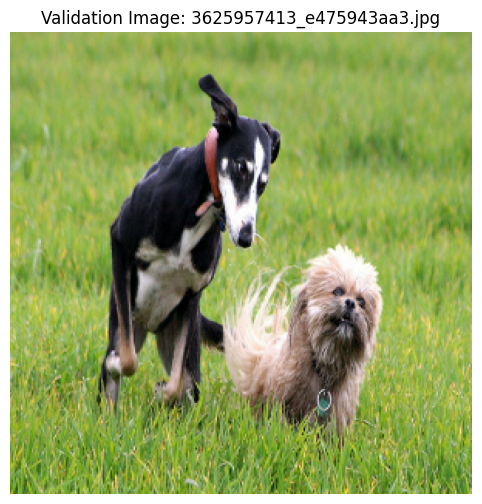

Generated Caption: a dog runs through the grass
Caption Length: 6 words
--------------------------------------------------

--- Validation Sample 2 ---


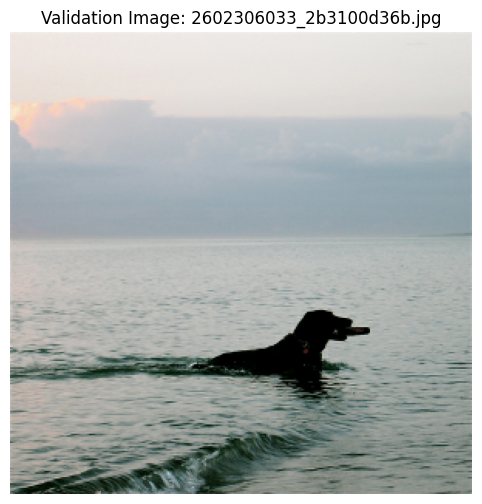

Generated Caption: a black dog is jumping into the water
Caption Length: 8 words
--------------------------------------------------

--- Validation Sample 3 ---


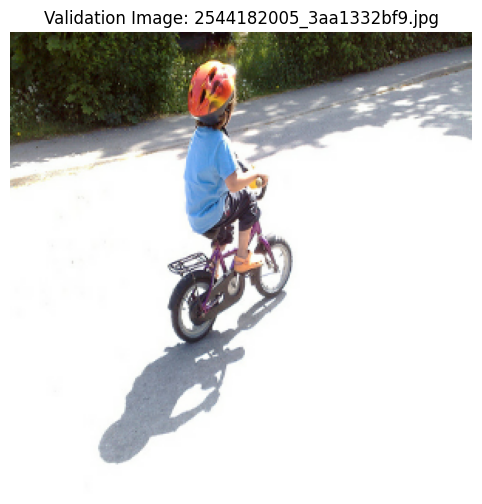

Generated Caption: a young girl in a pink shirt is riding a bike
Caption Length: 11 words
--------------------------------------------------

Caption generation testing complete!
To test custom images, use: test_image('path/to/your/image.jpg')


In [22]:
# Initialize caption generation components from trained model
vocab = vectorization.get_vocabulary()                    # Get learned vocabulary from vectorization layer
index_lookup = dict(zip(range(len(vocab)), vocab))       # Create token ID to word mapping
max_decoded_sentence_length = SEQ_LENGTH - 1             # Maximum caption length (excluding start token)
valid_images = list(valid_data.keys())                   # List of validation image paths

# Display generation setup information
print(f"Caption Generation Setup:")
print(f"├── Vocabulary size: {len(vocab):,} tokens")
print(f"├── Available validation images: {len(valid_images)}")
print(f"├── Maximum caption length: {max_decoded_sentence_length} tokens")
print(f"└── Special tokens: '<start>', '<end>', and padding")

def generate_caption():
    """
    Generate caption for a randomly selected validation image using trained model.

    This function implements autoregressive caption generation:
    1. Randomly selects a validation image
    2. Processes image through CNN and encoder
    3. Generates caption token by token using decoder
    4. Stops when <end> token is predicted or max length reached

    Returns:
        Generated caption string (cleaned of special tokens)
    """
    # Randomly select a validation image for testing
    sample_img_path = np.random.choice(valid_images)

    # Load and preprocess the selected image
    sample_img = decode_and_resize(sample_img_path)

    # Display the input image for visual verification
    img_display = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f'Validation Image: {os.path.basename(sample_img_path)}')
    plt.show()

    # FEATURE EXTRACTION PHASE
    # Process image through CNN feature extractor
    img = tf.expand_dims(sample_img, 0)                   # Add batch dimension
    img_features = caption_model.cnn_model(img, training=False)  # Extract CNN features
    encoded_img = caption_model.encoder(img_features, training=False)  # Process through encoder

    # AUTOREGRESSIVE CAPTION GENERATION PHASE
    # Start caption generation with special start token
    decoded_caption = "<start>"

    # Generate caption token by token (autoregressive decoding)
    for i in range(max_decoded_sentence_length):
        # Prepare current caption as input sequence
        tokenized_caption = vectorization([decoded_caption])[:, :-1]  # Vectorize and remove last token
        mask = tf.math.not_equal(tokenized_caption, 0)               # Create padding mask

        # Get next token predictions from decoder
        predictions = caption_model.decoder(
            tokenized_caption,      # Current caption sequence
            encoded_img,           # Image features from encoder
            training=False,        # Inference mode
            mask=mask             # Padding mask
        )

        # Convert logits to probabilities and select most likely token
        probabilities = tf.nn.softmax(predictions[0, i, :])  # Apply softmax to get probabilities
        sampled_token_index = np.argmax(probabilities)       # Select token with highest probability
        sampled_token = index_lookup[sampled_token_index]    # Convert token ID to word

        # Stop generation if end token is predicted
        if sampled_token == "<end>":
            break

        # Add predicted token to caption
        decoded_caption += " " + sampled_token

    # CAPTION CLEANING AND FORMATTING
    # Remove special tokens and clean up formatting
    decoded_caption = decoded_caption.replace("<start>", "").strip()  # Remove start token
    decoded_caption = decoded_caption.replace("<end>", "").strip()    # Remove end token (if present)

    # Display and return the generated caption
    print(f"Generated Caption: {decoded_caption}")
    return decoded_caption

def test_image(image_path):
    """
    Generate caption for a custom image file.

    Args:
        image_path: Path to the image file to caption

    Returns:
        Generated caption string or None if error occurs
    """
    try:
        # Validate file exists
        if not os.path.exists(image_path):
            print(f"Error: File not found - {image_path}")
            return None

        # Load and display the custom image
        sample_img = decode_and_resize(image_path)
        img_display = sample_img.numpy().clip(0, 255).astype(np.uint8)

        plt.figure(figsize=(8, 6))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f'Test Image: {os.path.basename(image_path)}')
        plt.show()

        # Generate caption using the same process as validation images
        img = tf.expand_dims(sample_img, 0)
        img_features = caption_model.cnn_model(img, training=False)
        encoded_img = caption_model.encoder(img_features, training=False)

        decoded_caption = "<start>"
        for i in range(max_decoded_sentence_length):
            tokenized_caption = vectorization([decoded_caption])[:, :-1]
            mask = tf.math.not_equal(tokenized_caption, 0)

            predictions = caption_model.decoder(
                tokenized_caption, encoded_img, training=False, mask=mask
            )

            probabilities = tf.nn.softmax(predictions[0, i, :])
            sampled_token_index = np.argmax(probabilities)
            sampled_token = index_lookup[sampled_token_index]

            if sampled_token == "<end>":
                break
            decoded_caption += " " + sampled_token

        # Clean and return caption
        decoded_caption = decoded_caption.replace("<start>", "").strip()
        decoded_caption = decoded_caption.replace("<end>", "").strip()

        print(f"Generated Caption: {decoded_caption}")
        return decoded_caption

    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def test_with_sampling(image_path, temperature=0.7):
    """
    Generate caption for a custom image using temperature sampling for diverse results.

    Temperature sampling introduces controlled randomness in token selection:
    - Lower temperature (0.1-0.5): More conservative, predictable captions
    - Medium temperature (0.6-0.9): Balanced creativity and accuracy
    - Higher temperature (1.0+): More creative but potentially less accurate

    Args:
        image_path: Path to the image file to caption
        temperature: Sampling temperature controlling randomness (default: 0.7)

    Returns:
        Generated caption string or None if error occurs
    """
    try:
        # Validate that the image file exists before processing
        if not os.path.exists(image_path):
            print(f"Error: File not found - {image_path}")
            return None

        # Load and preprocess the image for model input
        sample_img = decode_and_resize(image_path)

        # Convert tensor to displayable format for visualization
        img_display = sample_img.numpy().clip(0, 255).astype(np.uint8)

        # Display the input image with temperature information
        plt.figure(figsize=(8, 6))
        plt.imshow(img_display)
        plt.axis('off')
        plt.title(f'Test Image (T={temperature}): {os.path.basename(image_path)}')
        plt.show()

        # FEATURE EXTRACTION PHASE
        # Add batch dimension and extract features through CNN backbone
        img = tf.expand_dims(sample_img, 0)                           # Shape: (1, height, width, 3)
        img_features = caption_model.cnn_model(img, training=False)   # Extract CNN features
        encoded_img = caption_model.encoder(img_features, training=False)  # Process through transformer encoder

        # TEMPERATURE-BASED CAPTION GENERATION PHASE
        # Initialize caption with start token for autoregressive generation
        decoded_caption = "<start>"

        # Generate caption token by token using temperature sampling
        for i in range(max_decoded_sentence_length):
            # Prepare current caption sequence for decoder input
            tokenized_caption = vectorization([decoded_caption])[:, :-1]  # Convert to tokens, remove last
            mask = tf.math.not_equal(tokenized_caption, 0)               # Create padding mask

            # Get next token predictions from transformer decoder
            predictions = caption_model.decoder(
                tokenized_caption,      # Current caption sequence as input
                encoded_img,           # Image features from encoder
                training=False,        # Inference mode (no dropout)
                mask=mask             # Mask for padded tokens
            )

            # TEMPERATURE SAMPLING: Apply temperature scaling for controlled randomness
            logits = predictions[0, i, :] / temperature              # Scale logits by temperature
            probabilities = tf.nn.softmax(logits)                   # Convert to probabilities

            # Sample token based on probability distribution (not just max)
            sampled_token_index = tf.random.categorical([logits], 1)[0, 0]  # Probabilistic sampling
            sampled_token = index_lookup[int(sampled_token_index)]          # Convert ID to word

            # Stop generation if end token is sampled
            if sampled_token == "<end>":
                break

            # Add sampled token to growing caption
            decoded_caption += " " + sampled_token

        # CAPTION CLEANING AND FORMATTING
        # Remove special tokens and clean up spacing
        decoded_caption = decoded_caption.replace("<start>", "").strip()  # Remove start token
        decoded_caption = decoded_caption.replace("<end>", "").strip()    # Remove end token if present

        # Display generated caption with temperature information
        print(f"Generated Caption (T={temperature}): {decoded_caption}")
        return decoded_caption

    except Exception as e:
        # Handle any errors during image processing or caption generation
        print(f"Error processing image: {str(e)}")
        return None

# ============================================================================
# VALIDATION IMAGE TESTING
# ============================================================================

# Test caption generation with multiple validation images
print("\nTesting caption generation with validation images:")
print("=" * 60)

for i in range(3):
    print(f"\n--- Validation Sample {i+1} ---")
    try:
        generated_caption = generate_caption()
        print(f"Caption Length: {len(generated_caption.split())} words")
    except Exception as e:
        print(f"Error generating caption: {str(e)}")
    print("-" * 50)

print(f"\nCaption generation testing complete!")
print(f"To test custom images, use: test_image('path/to/your/image.jpg')")

## Custom Image Testing




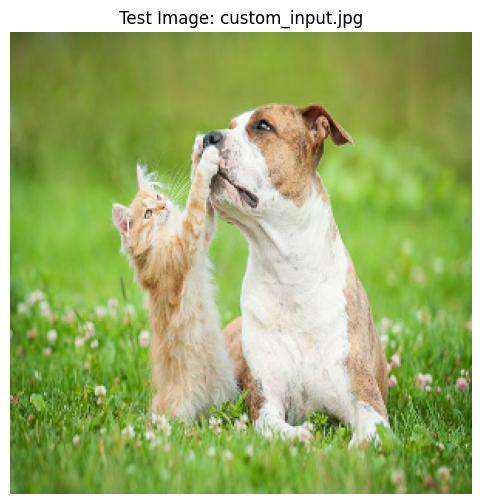

Generated Caption: a brown and white dog is running through a field


'a brown and white dog is running through a field'

In [24]:
# Replace "/content/my_photo.jpg" with your actual image path

# Test with a single image
test_image("/content/my_photo.jpg")

# Test with temperature sampling for variety
test_with_sampling("/content/my_photo.jpg", temperature=0.8)

# Test multiple images
image_paths = ["image1.jpg", "image2.jpg", "image3.jpg"]
for path in image_paths:
    test_image(path)